# An example of the Nonlinear inference.

This notebook briefly shows an inference examples for non-linear model with GPinv

*Keisuke Fujii 3rd Oct. 2016*

## Synthetic observation

Consider we observe a cylindrical transparent mediam with multiple ($N$) lines-of-sight, as shown below.

<img src=figs/abel_inversion.png width=240pt>

The local emission intensity $g$ is a function of the radius $r$.
The observed emission intensity $\mathbf{Y}$ is a result of the integration along the line-of-sight as
$$
\mathbf{Y} = \int_{x} g(r) dx + \mathbf{e}
$$

where $\mathbf{e}$ is a i.i.d. Gaussian noise.

We divided $g$ into $n$ discrete points $\mathbf{g}$, then the above integration can be approximated as follows
$$
\mathbf{Y} = \mathrm{A} \mathbf{g} + \mathbf{e}
$$

## Non-linear model and transform

To make sure $g(r)$ is positive, we define new function $f$,
$$
g(r) = \exp(f(r))
$$
Here, we assume $f(r)$ follows the Gaussian Process with kernel $\mathrm{K}$.
This transformation makes the problem non-linear.

In this notebook, we infer $\mathbf{g}$ by 
1. Stochastic approximation of the variational Gaussian process.
2. Markov Chain Monte-Carlo (MCMC) method.

## Import several libraries including GPinv

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
import sys
# In ../testing/ dir, we prepared a small script for generating the above matrix A
sys.path.append('../testing/')
import make_LosMatrix
# Import GPinv
import GPinv

# random state
rng = np.random.RandomState(0)

## Synthetic signals

Here, we make a synthetic measurement.
The synthetic signal $\mathrm{y}$ is simulated from the grand truth solution $g_true$ and random gaussian noise.

In [2]:
n = 30
N = 40
# radial coordinate
r = np.linspace(0, 1., n)
# synthetic latent function
f = np.exp(-(r-0.3)*(r-0.3)/0.1) + np.exp(-(r+0.3)*(r+0.3)/0.1)

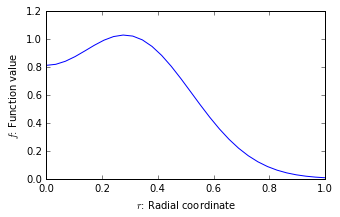

In [3]:
# plotting the latent function
plt.figure(figsize=(5,3))
plt.plot(r, f)
plt.xlabel('$r$: Radial coordinate')
plt.ylabel('$f$: Function value')

### Prepare the synthetic signal.

In [4]:
# los height
z = np.linspace(-0.9,0.9, N)
# Los-matrix
A = make_LosMatrix.make_LosMatrix(r, z)

In [5]:
# noise amplitude 
e_amp = 0.1
# synthetic observation
y = np.dot(A, f) + e_amp * rng.randn(N)

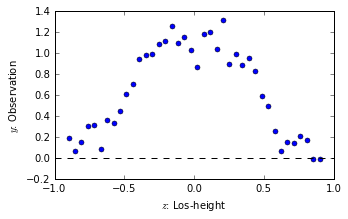

In [6]:
plt.figure(figsize=(5,3))
plt.plot(z, y, 'o', [-1,1],[0,0], '--k', ms=5)
plt.xlabel('$z$: Los-height')
plt.ylabel('$y$: Observation')

# Inference

In order to carry out an inference, a custom **likelihood**, which calculates $p(\mathbf{Y}|\mathbf{f})$ with given $\mathbf{f}$, must be prepared according to the problem.

The method to be implemented is **logp(f,Y)** method, that calculates log-likelihood for data **Y** with given **f**

In [7]:
class AbelLikelihood(GPinv.likelihoods.Likelihood):
    def __init__(self, Amat):
        GPinv.likelihoods.Likelihood.__init__(self)
        self.Amat = GPinv.param.DataHolder(Amat)
        self.variance = GPinv.param.Param(np.ones(1), GPinv.transforms.positive)

    def logp(self, F, Y):
        """
        This method is used to estimate the ELBO.
        """
        Af = self.F(F)
        Y = tf.tile(tf.expand_dims(Y, 0), [tf.shape(F)[0],1,1])
        return GPinv.densities.gaussian(Af, Y, self.variance)
    
    def F(self, F):
        """
        This method can be used to sample from posterior after the optimization.
        """
        N = tf.shape(F)[0]
        Amat = tf.tile(tf.expand_dims(self.Amat,0), [N, 1,1])
        Af = tf.batch_matmul(Amat, tf.exp(F))
        return Af
    
    def Y(self, F):
        f_sample = self.F(F)
        return f_sample + tf.random_normal(tf.shape(f_sample)) * tf.sqrt(self.variance)

## Variational inference by StVGP

In StVGP, we evaluate the posterior $p(\mathbf{f}|\mathbf{y},\theta)$ by approximating as a multivariate Gaussian distribution.

The hyperparameters are obtained at the maximum of the evidence lower bound (ELBO) $p(\mathbf{y}|\theta)$.

### Kernel

The statistical property is interpreted in Gaussian Process kernel.
In our example, since $f$ is a cylindrically symmetric function, we adopt **RBF_csym** kernel.

### MeanFunction

To make $f$ scale invariant, we added the constant mean_function to $f$.

In [8]:
model_stvgp = GPinv.stvgp.StVGP(r.reshape(-1,1), y.reshape(-1,1), 
                           kern = GPinv.kernels.RBF_csym(1,1),
                           mean_function = GPinv.mean_functions.Constant(1),
                           likelihood=AbelLikelihood(A),
                           num_samples=10)

## Check the initial estimate

In [9]:
# Data Y should scatter around the transform F of the GP function f.
sample_F = model_stvgp.sample_from_('F', 100)

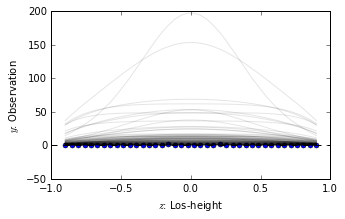

In [10]:
plt.figure(figsize=(5,3))
plt.plot(z, y, 'o', [-1,1],[0,0], '--k', ms=5)
for s in sample_F:
    plt.plot(z, s, '-k', alpha=0.1, lw=1)
plt.xlabel('$z$: Los-height')
plt.ylabel('$y$: Observation')

## Iteration

Although the initial estimate is not very good, we start iteration.

In [11]:
# This function is just for the visualization of the iteration
from IPython import display

logf = []
def logger(x):
    if (logger.i % 10) == 0:
        obj = -model_stvgp._objective(x)[0]
        logf.append(obj)
        # display
        if (logger.i % 100) ==0:
            plt.clf()
            plt.plot(logf, '--ko', markersize=3, linewidth=1)
            plt.ylabel('ELBO')
            plt.xlabel('iteration')
            display.display(plt.gcf())
            display.clear_output(wait=True)
    logger.i+=1
logger.i = 1

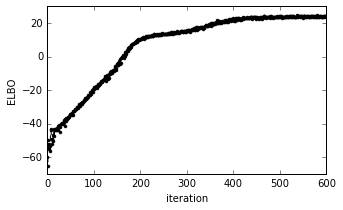

In [12]:
plt.figure(figsize=(5,3))
# Rough optimization by scipy.minimize
model_stvgp.optimize()
# Final optimization by tf.train
trainer = tf.train.AdamOptimizer(learning_rate=0.0025)
_= model_stvgp.optimize(trainer, maxiter=6000, callback=logger)

display.clear_output(wait=True)

## Plot results

In [13]:
# Predict the latent function f, which follows Gaussian Process
r_new = np.linspace(0.,1.2, 40)
f_pred, f_var = model_stvgp.predict_f(r_new.reshape(-1,1))

# Data Y should scatter around the transform F of the GP function f.
sample_F = model_stvgp.sample_from_('F', 100)

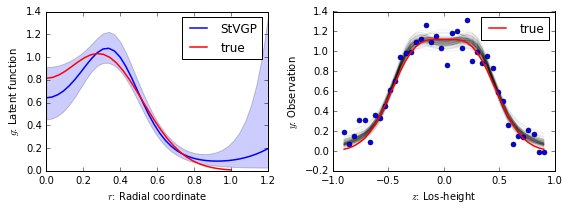

In [14]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
f_plus = np.exp(f_pred.flatten() + 2.*np.sqrt(f_var.flatten()))
f_minus = np.exp(f_pred.flatten() - 2.*np.sqrt(f_var.flatten()))
plt.fill_between(r_new, f_plus, f_minus, alpha=0.2)
plt.plot(r_new, np.exp(f_pred.flatten()), label='StVGP',lw=1.5)
plt.plot(r, f, '-r', label='true',lw=1.5)# ground truth
plt.xlabel('$r$: Radial coordinate')
plt.ylabel('$g$: Latent function')
plt.legend(loc='best')

plt.subplot(1,2,2)
for s in sample_F:
    plt.plot(z, s, '-k', alpha=0.05, lw=1)
plt.plot(z, y, 'o', ms=5)
plt.plot(z, np.dot(A, f), 'r', label='true',lw=1.5)
plt.xlabel('$z$: Los-height')
plt.ylabel('$y$: Observation')
plt.legend(loc='best')

plt.tight_layout()

# MCMC

MCMC is fully Bayesian inference.
The hyperparameters are numerically marginalized out.

In [15]:
model_gpmc = GPinv.gpmc.GPMC(r.reshape(-1,1), y.reshape(-1,1), 
                           kern = GPinv.kernels.RBF_csym(1,1),
                           mean_function = GPinv.mean_functions.Constant(1),
                           likelihood=AbelLikelihood(A))

## Sample from posterior

In [16]:
samples = model_gpmc.sample(300, thin=3, burn=500, verbose=True, epsilon=0.01, Lmax=15)

burn-in sampling started
Iteration:  100 	 Acc Rate:  97.0 %
Iteration:  200 	 Acc Rate:  93.0 %
Iteration:  300 	 Acc Rate:  96.0 %
Iteration:  400 	 Acc Rate:  96.0 %
Iteration:  500 	 Acc Rate:  100.0 %
burn-in sampling ended
Iteration:  100 	 Acc Rate:  90.0 %
Iteration:  200 	 Acc Rate:  94.0 %
Iteration:  300 	 Acc Rate:  97.0 %
Iteration:  400 	 Acc Rate:  97.0 %
Iteration:  500 	 Acc Rate:  96.0 %
Iteration:  600 	 Acc Rate:  95.0 %
Iteration:  700 	 Acc Rate:  92.0 %
Iteration:  800 	 Acc Rate:  91.0 %
Iteration:  900 	 Acc Rate:  95.0 %


## Plot result

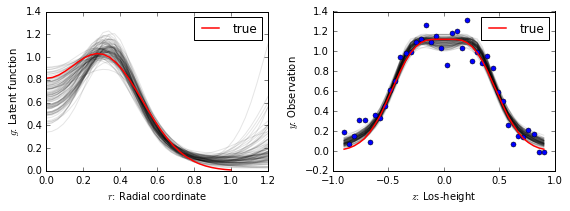

In [17]:
r_new = np.linspace(0.,1.2, 40)

plt.figure(figsize=(8,3))
# Latent function
plt.subplot(1,2,1)
for i in range(0,len(samples),3):
    s = samples[i]
    model_gpmc.set_state(s)
    f_pred, f_var = model_gpmc.predict_f(r_new.reshape(-1,1))
    plt.plot(r_new, np.exp(f_pred.flatten()), 'k',lw=1, alpha=0.1)
plt.plot(r, f, '-r', label='true',lw=1.5)# ground truth
plt.xlabel('$r$: Radial coordinate')
plt.ylabel('$g$: Latent function')
plt.legend(loc='best')

#     
plt.subplot(1,2,2)
for i in range(0,len(samples),3):
    s = samples[i]
    model_gpmc.set_state(s)
    f_sample = model_gpmc.sample_from_('F',1)
    plt.plot(z, f_sample[0], 'k',lw=1, alpha=0.1)
plt.plot(z, y, 'o', ms=5)
plt.plot(z, np.dot(A, f), 'r', label='true',lw=1.5)
plt.xlabel('$z$: Los-height')
plt.ylabel('$y$: Observation')
plt.legend(loc='best')

plt.tight_layout()

# Comparison between StVGP and GPMC

The StVGP makes a point estimate for the hyperparameter (variance and length-scale of the kernel, mean function value, and variance at the likelihood), 
while the GPMC integrate them out.

Therefore, there is some difference between them.

## Difference in the hyperparameter estimation

In [18]:
# make a histogram (posterior) for these hyperparameter estimated by GPMC
gpmc_hyp_samples = {
    'k_variance' :   [], # variance 
    'k_lengthscale': [], # kernel lengthscale
    'mean' : [], # mean function values
    'lik_variance' : [], # variance for the likelihood
}
for s in samples:
    model_gpmc.set_state(s)
    gpmc_hyp_samples['k_variance'   ].append(model_gpmc.kern.variance.value[0])
    gpmc_hyp_samples['k_lengthscale'].append(model_gpmc.kern.lengthscales.value[0])
    gpmc_hyp_samples['mean'].append(model_gpmc.mean_function.c.value[0])
    gpmc_hyp_samples['lik_variance'].append(model_gpmc.likelihood.variance.value[0])

Here the red line shows the MAP estimate by StVGP


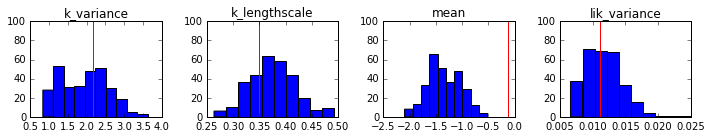

In [19]:
plt.figure(figsize=(10,2))
# kernel variance
plt.subplot(1,4,1)
plt.title('k_variance')
_= plt.hist(gpmc_hyp_samples['k_variance'])
plt.plot([model_stvgp.kern.variance.value]*2, [0,100], '-r')
plt.subplot(1,4,2)
plt.title('k_lengthscale')
_= plt.hist(gpmc_hyp_samples['k_lengthscale'])
plt.plot([model_stvgp.kern.lengthscales.value]*2, [0,100], '-r')
plt.subplot(1,4,3)
plt.title('mean')
_= plt.hist(gpmc_hyp_samples['mean'])
plt.plot([model_stvgp.mean_function.c.value]*2, [0,100], '-r')
plt.subplot(1,4,4)
plt.title('lik_variance')
_= plt.hist(gpmc_hyp_samples['lik_variance'])
plt.plot([model_stvgp.likelihood.variance.value]*2, [0,100], '-r')

plt.tight_layout()

print('Here the red line shows the MAP estimate by StVGP')

## Difference in the prediction.

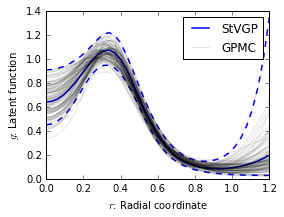

In [20]:
r_new = np.linspace(0.,1.2, 40)

plt.figure(figsize=(4,3))
# StVGP
f_pred, f_var = model_stvgp.predict_f(r_new.reshape(-1,1))
f_plus = np.exp(f_pred.flatten() + 2.*np.sqrt(f_var.flatten()))
f_minus = np.exp(f_pred.flatten() - 2.*np.sqrt(f_var.flatten()))
plt.plot(r_new, np.exp(f_pred.flatten()), 'b', label='StVGP',lw=1.5)
plt.plot(r_new, f_plus, '--b', r_new, f_minus, '--b', lw=1.5)

# GPMC
for i in range(0,len(samples),3):
    s = samples[i]
    model_gpmc.set_state(s)
    f_pred, f_var = model_gpmc.predict_f(r_new.reshape(-1,1))
    plt.plot(r_new, np.exp(f_pred.flatten()), 'k',lw=1, alpha=0.1)
plt.plot(r_new, np.exp(f_pred.flatten()), 'k',lw=1, alpha=0.1, label='GPMC')

plt.xlabel('$r$: Radial coordinate')
plt.ylabel('$g$: Latent function')
plt.legend(loc='best')